In [54]:
import pandas as pd
import numpy as np
from torch import nn
import torch

import matplotlib.pyplot as plt

# Tensors

In [24]:
x=torch.rand(2,3)

In [25]:
torch.randint(5,(2,2))

tensor([[1, 3],
        [2, 1]])

# RNN

$$h_t=\tanh(W_{ih}x_t+b_{ih}+W_{hh}h_{t-1}+b_{hh})$$  

In [32]:
torch.__version__

'1.10.0'

In [33]:
bsize=5
input_size=3
seq_len=7

In [34]:
x=torch.rand(bsize,seq_len,input_size)
x.size()

torch.Size([5, 7, 3])

In [35]:
rnn=nn.RNN(input_size=input_size,hidden_size=4,num_layers=1,batch_first=True)

In [36]:
rnn_unit=nn.RNN(input_size=input_size,hidden_size=4,num_layers=1,batch_first=True)

In [37]:
rnn.weight_ih_l0=rnn_unit.weight_ih_l0
rnn.weight_hh_l0=rnn_unit.weight_hh_l0
rnn.bias_hh_l0=rnn_unit.bias_hh_l0
rnn.bias_ih_l0=rnn_unit.bias_ih_l0

In [39]:
out, hidden=rnn(x)

In [40]:
ys=[]
for i in range(seq_len):
    if i==0:
        y,hidden=rnn_unit(x[:,i:i+1,:])
        ys.append(y)
    else:
        y,hidden=rnn_unit(x[:,i:i+1,:],hidden)
        ys.append(y)
y=torch.cat(ys,dim=1)

In [49]:
hidden.size()

torch.Size([1, 5, 4])

In [50]:
y.size()

torch.Size([5, 7, 4])

In [47]:
(out-y).sum()

tensor(0., grad_fn=<SumBackward0>)

## Regression

In [73]:
from sklearn.model_selection import train_test_split

In [67]:
x=np.arange(-10,10,0.2)
y=np.cos(x)+np.sin(x)*np.sin(x)*x

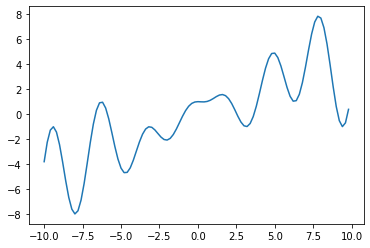

In [68]:
plt.plot(x,y)

In [72]:
ydata=np.concatenate([y[:-1].reshape(-1,1),y[1:].reshape(-1,1)],axis=1)

In [139]:
L=y.shape[0]
idx=np.arange(L)
seq_len=3
idx_split=np.arange(0,L,seq_len)[1:]
i,j=ydata.shape
data=np.split(ydata.reshape(1,i,j),idx_split,axis=1)
data=[d for d in data if d.shape==(1,seq_len,2)]
np.random.shuffle(data)

In [140]:
bsize=3
batches=[]
for i in range(0,len(data),bsize):
    t=data[i:i+bsize]
    b=np.concatenate(data[i:i+bsize],axis=0)
    batches.append(b)

In [142]:
len(batches)

11

In [211]:
test_size=int(0.2*len(batches))
train=batches[:-test_size]
test=batches[test_size:]

In [160]:
class Dataset:
    def __init__(self,data):
        self.data=data
    def __len__(self):
        return len(self.data)
    def __getitem__(self,i):
        x=self.data[i][:,:,0:1]
        y=self.data[i][:,:,1:]

        return torch.Tensor(x),torch.Tensor(y)

In [212]:
dtrain=Dataset(train)
dtest=Dataset(test)

## Model

In [169]:
class Model(nn.Module):
    def __init__(self,input_size,output_size,hidden_size,num_layers):
        super(Model,self).__init__()
        self.rnn=nn.RNN(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        out,_=self.rnn(x)
        out=self.fc(out)

        return out

In [214]:
input_size=1
output_size=1
hidden_size=3
num_layers=1
model=Model(input_size,output_size,hidden_size,num_layers)

In [215]:
loss=torch.nn.MSELoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

In [216]:
def train(model,traindl, loss, optimizer,epochs):
    
    for epoch in range(epochs):
        total_loss=0
        for b in traindl:
            bx,by=b
            optimizer.zero_grad()
            y=model(bx)
            los=loss(y.view(-1,1),by.view(-1,1))
            los.backward()
            optimizer.step()
            total_loss+=los
        print(f'Epoch: {epoch}, Loss: ',total_loss.item())

In [222]:
train(model,dtrain,loss,optimizer,10)

Epoch: 0, Loss:  5.852273464202881
Epoch: 1, Loss:  5.7920756340026855
Epoch: 2, Loss:  5.734556674957275
Epoch: 3, Loss:  5.679584980010986
Epoch: 4, Loss:  5.6270294189453125
Epoch: 5, Loss:  5.576760292053223
Epoch: 6, Loss:  5.528659343719482
Epoch: 7, Loss:  5.482606887817383
Epoch: 8, Loss:  5.438493251800537
Epoch: 9, Loss:  5.396213054656982


## Prediction

In [223]:
def eval(model,test,loss=loss):
    model.eval()
    los=0
    for b in test:
        bx,by=b
        y=model(bx)
        los+=loss(y.view(-1,1),by.view(-1,1))
    print(los.item())


In [226]:
ytorch=torch.Tensor(y)

In [240]:
ypred=model(ytorch.view(1,-1,1)).detach().numpy()

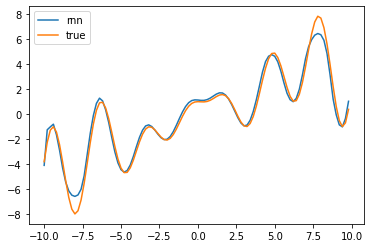

In [245]:
plt.plot(x,ypred.reshape(-1))
plt.plot(x,y)
plt.legend(['rnn','true'])

# Text Generation